In [1]:
from htc_vive_trace_analyzer import ViveTraceAnalyzer
import trimesh
import numpy as np


bags = [
    '../data/roller_trace_bag_2020-12-09-15-04-33.bag'
]



bag_file_path = '../data/roller_trace_bag_2020-12-09-15-04-33.bag'

ana = ViveTraceAnalyzer()
ana.load_from_bag(bag_file_path)
ana.calc_point_density()

/opt/ros/noetic/lib/python3/dist-packages/tf/listener.py:63: UserWarning: translation should be of type Vector3
  self._buffer.set_transform(transform, authority)
/opt/ros/noetic/lib/python3/dist-packages/tf/listener.py:63: UserWarning: rotation should be of type Quaternion
  self._buffer.set_transform(transform, authority)
/home/meowxiik/Cloud/PCIIRC/tool-scanner/scripts/tf_bag.py:99: UserWarning: translation should be of type Vector3
  self.transformer._buffer.set_transform_static(st_tfm, "default_authority")
/home/meowxiik/Cloud/PCIIRC/tool-scanner/scripts/tf_bag.py:99: UserWarning: rotation should be of type Quaternion
  self.transformer._buffer.set_transform_static(st_tfm, "default_authority")


/usr/lib/python3/dist-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


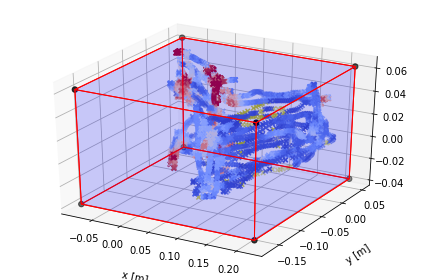

In [2]:
ana.draw_points_density(density_threshold=5)

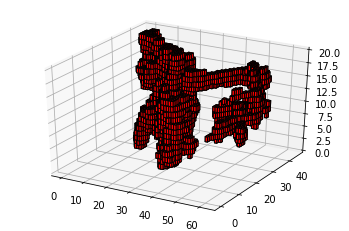

In [3]:
ana.plot_voxels()

In [4]:
ana.show_bb(density_threshold=5)

[ 0.0725 -0.06    0.0125]


TrackedArray([[-0.0825, -0.1725,  0.0625],
              [ 0.2275, -0.1725,  0.0625],
              [-0.0825,  0.0525,  0.0625],
              [ 0.2275,  0.0525,  0.0625],
              [-0.0825, -0.1725, -0.0375],
              [ 0.2275, -0.1725, -0.0375],
              [-0.0825,  0.0525, -0.0375],
              [ 0.2275,  0.0525, -0.0375]])

In [5]:
import trimesh

density_threshold = 18
voxels = (ana.density >= density_threshold)
voxelgrid = trimesh.voxel.VoxelGrid(voxels, transform=ana.transform)


In [6]:
voxelgrid.show()

In [7]:
mesh = voxelgrid.as_boxes()
mesh.bounding_box.show()

In [8]:
import os

def optimize_bb(ana, density_threshold=18, render=False, ret_scene=False):
    self = ana
    voxels = (self.density >= density_threshold)
    voxelgrid = trimesh.voxel.VoxelGrid(voxels, transform=self.transform)
    # voxelgrid.show()

    from scipy.optimize import fmin

    def rotate_to_min(angle):
        trans = trimesh.transformations.euler_matrix(0, 0, angle)
        optimesh = voxelgrid.copy()
        volume = optimesh.apply_transform(trans).as_boxes().bounding_box.volume
        return volume * 10000000

    # res = fmin(rotate_to_min, x0=np.array([0.0]), full_output=True)
    # res = fmin(rotate_to_min, x0=0.0, ftol=0.0000001, xtol=0.0000001, full_output=True)

    in_space = np.linspace(0.0, 0.5 *np.pi, 90*10)
    res = [rotate_to_min(x) for x in in_space]
    res = np.array(res)
    min = res.min()
    x_opt = res[res==min]


    trans = trimesh.transformations.euler_matrix(0, 0, x_opt)
    optimesh = voxelgrid.copy()
    optimesh = optimesh.as_boxes()
    optimesh.apply_transform(trans)

    bb = optimesh.bounding_box
    bb.visual.main_color[3] = 150
    bb.visual.face_colors[:, 3] = 150
    scene = (optimesh + bb).show()

    np.savetxt(os.path.join(self.folder, self.bag_name + '_bb_corners_z_aligned.csv'), bb.vertices, delimiter=',')

    scene = optimesh.scene()
    scene.add_geometry(bb)
    if render:
        self.render_views(scene, self.folder, name='optibox')



    print(res)
    # mesh = voxelgrid.as_boxes()
    #
    # bb = mesh.bounding_box_oriented
    # assert isinstance(bb, trimesh.primitives.Box)
    # bb.visual.main_color[3] = 150
    # bb.visual.face_colors[:, 3] = 150
    # scene = (mesh + bb).show()
    # # scene.save_image()
    #
    # # self.render_mesh(scene, path=os.path.join(self.folder, 'voxel_mesh_bb.png'))
    #
    # # mesh.vertices
    # print(bb.center_mass)

    # np.savetxt(os.path.join(self.folder, 'bb_corners.csv'), bb.vertices, delimiter=',')
    if ret_scene:
        return bb.vertices, scene, res
    return bb.vertices


In [9]:
vert, scene, res = optimize_bb(ana=ana, density_threshold=18, render=False, ret_scene=True)


[67500.         67551.56579636 67602.73697959 67653.51292481
 67703.89301194 67753.87662576 67803.46315587 67852.65199674
 67901.44254768 67949.83421287 67997.82640135 68045.41852707
 68092.61000882 68139.40027033 68185.78874019 68231.77485191
 68277.35804393 68322.5377596  68367.31344718 68411.68455988
 68455.65055585 68499.21089819 68542.36505495 68585.11249914
 68627.45270873 68669.38516667 68710.90936089 68752.02478432
 68792.73093484 68833.02731537 68872.91343382 68912.3888031
 68951.45294115 68990.10537092 69028.3456204  69066.17322261
 69103.5877156  69140.58864248 69177.17555139 69213.34799555
 69249.10553322 69284.44772774 69319.37414751 69353.88436603
 69387.97796186 69421.65451865 69454.91362516 69487.75487523
 69520.1778678  69552.18220695 69583.76750183 69614.93336673
 69645.67942105 69676.00528935 69705.91060128 69735.39499164
 69764.45810037 69793.09957257 69821.31905847 69849.11621346
 69876.49069808 69903.44217804 69929.97032422 69956.07481266
 69981.75532458 70007.011

In [45]:
# res[res==res.min()]
np.argmin(res)


375

In [54]:
import spatialmath as sm


scene.geometry['geometry_1'].visual.face_colors[:, 3] = 150
scene.geometry['geometry_1'].visual.main_color[3] = 150
# assert isinstance(box, trimesh.primitives.Box)

# box.visual.face_colors[:, 3] = 150

view = sm.SE3.Rand(xrange=(0,0),
                            yrange=(0,0),
                            zrange=(0,0)).A

# scene.apply_transform(view)
scene.graph[scene.camera.name] = view

In [58]:
scene.show()

In [62]:
scene.camera_transform

array([[-0.85274598,  0.06838223,  0.51783025, -0.54810995],
       [ 0.24394201, -0.82449128,  0.51059419,  0.        ],
       [ 0.46186209,  0.5617277 ,  0.68640032,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [63]:
# ana.render_mesh(scene[1], 'mymesh.png')

data = scene.save_image(resolution=(1024, 768), visible=True)


from PIL import Image
from PIL.PngImagePlugin import PngImageFile
rendered = Image.open(trimesh.util.wrap_as_stream(data))
# file = open('mymesh.png', 'w+')
# # file.write(data)
# file.write(rendered)
# file.close()
assert isinstance(rendered, PngImageFile)
rendered.save('mymesh.png')

In [7]:
png = ana.render_mesh(scene[1])
png

b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x00\x00\x00\x03\x00\x08\x06\x00\x00\x00\xba\xba\x15\r\x00\x00Y2IDATx\x9c\xed\xddKw\x14g\x9a\'\xf07"%{\x95B \xb7\x80*IS\x14\x9e\xb1\xaaJ\xe0b\xd3>\xd3\xe5Y\xcd\xa5j\xea\xfb\xcdWq\xf7\xa6v\xd0\x0b6v\x1b\xa9\x8d\xce\x0cn\x1f$;\x85\xb0\x84\xa4\\\x81\x94\x19\xb3\xa0B\x16\xa0KfFd\\\x7f\xbfs|, /\x0f(\x95\x19\xcf\xff\xbdE\xff\xe7\xff\xfc\x9f$\x00\x00\x00\x00\x8d\x16\x97]\x00\x00\x00\x000}\x02\x00\x00\x00\x00h\x01\x01\x00\x00\x00\x00\xb4\x80\x00\x00\x00\x00\x00Z@\x00\x00\x00\x00\x00- \x00\x00\x00\x00\x80\x16\x98)\xbb\x80Q\x1d\x1d\x1d\x85\x87\x0f\x1f\x96]F.\xee\xdf\xbf\x1f\x96\x96\x96\xca.\x03\x00\x00\x80\x161\x03\xa0\x04\x9b\x9b\x9ba{{\xbb\xec2\x00\x00\x00h\x11\x01@I677\xc3\x93\'O\xca.\x03\x00\x00\x80\x96\x10\x00\x94hww7<y\xf2$\xf4\xfb\xfd\xb2K\x01\x00\x00\xa0\xe1\x04\x00%\xdb\xdd\xdd\r\x8f\x1f?\x16\x02\x00\x00\x000U\x02\x80\x8ax\xfc\xf8\xb1}\x01\x00\x00\x00\x98\x1a\x01@\x85\xd8\x1c\x10\x00\x00\x80i\x11\x00T\x8c\x10\x00\x00\x00\x80i\x10\x00T\x90

In [ ]:
ana.select_bb(density_threshold=5)